  # AI on the edge

Deep learning on small devices


- Motivation
- Deep nets for devices
- Running deep nets on devices

## Why run AI on devices?

![cloud](assets/lsvm-machine-learning-cloud.jpg)

![data center](assets/how_safe_datacenter.jpg)

<img src='assets/GDP-Complience-V02-72dpi-RGB-01.jpg' width='70%'/>

<img src='assets/qualcomm_on_device_intelligence.png' width='80%'/>

## What can run (fast enough) on devices?

## AlexNet (2012)

<img src="assets/alexnet.png"/>

60 million parameters, 720 million multiply-adds

[paper](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)

## SqueezeNet (2016)

<img src='assets/squeezenet_unit.png' width='800'/>

[source](https://github.com/DeepScale/SqueezeNet)

<img src='assets/squeezenet_arch.png' width='55%'/>
<img src='assets/squeezenet_bypass.png' width='60%'/>

<img src='assets/squeezenet_compare.png'/>

## MobileNet (2017)

Convolution:

$$h_i.w_i.d_i.d_j.k^2$$

Depthwise separable convolution:

$$h_i.w_i.d_i(d_j+k^2)$$

[paper](https://arxiv.org/abs/1704.04861v1)

<img src='assets/depthwise_separable_conv_unit.png' width='400' style='float:left;'/>
<img src='assets/depthwise_separable_conv_layer.png' width='400' style='float:left;'/>

<img src='assets/mobilenet_res.png' width='800'/>
<img src='assets/mobilenet_acc.png' width='40%'/>

## ShuffleNet (2017)

<img src='assets/shufflenet_channelshuffle.png'/>

[paper](https://arxiv.org/abs/1707.01083)

<img src='assets/shufflenet_unit.png'/>

<img src='assets/shufflenet_compare_class.png'/>

## MobileNet V2 (2018)

Convolution: 

$$h_i.w_i.d_i.d_j.k^2$$

Depthwise separable (MobileNet V1):

$$h_i.w_i.d_i(d_j+k^2)$$

Depthwise bottleneck + residuals (MobileNet V2):

$$h_i.w_i.d_i.t(d_i+d_j+k^2)$$

[paper](https://arxiv.org/abs/1801.04381)

<img src='assets/mobilenetv2_block_compare.png' width='55%'/>

<img src='assets/mobilenetv2_compare.png' width='55%'/>

<img src='assets/mobilenetv2_curve.png' width='80%'/>

## How to run on devices?

## CoreML

- download pre-trained .mlmodel
  - or convert from Caffe, Tensorflow, ONNX (Open Neural Network eXchange)
- add to XCode project to generate wrapper
  - use optional Vision library to preprocess images

[docs](https://developer.apple.com/documentation/coreml)

## Demo: Image Classification
---
CoreML on iOS Simulator

[github](https://github.com/hollance/MobileNet-CoreML)

|MobileNet|SqueezeNet|
|--|--|
|<img src='assets/coreml_mobilenet.png' width='400'/>|<img src='assets/coreml_sqeezenet.png' width='400'/>|

## TensorFlow / TensorFlow Lite

- Compilable to Raspbian
- TensorFlow Lite: optimized for Android, iOS

<img src='assets/tflite-architecture.jpg' width='500'/>

## Demo: Image Classification
---
Raspberry Pi 3 with TensorFlow

In [1]:
from __future__ import print_function

import tensorflow as tf
print("TensorFlow: ", tf.__version__)

import platform
print(", ".join(platform.uname()))

TensorFlow:  1.8.0
Linux, ce3ce3a37846, 4.14.34-v7+, #1110 SMP Mon Apr 16 15:18:51 BST 2018, armv7l, 


In [ ]:
from IPython import display

# download tensorflow models
!git clone https://github.com/tensorflow/models

In [3]:
# download a recent MobileNet V2 checkpoint
checkpoint_name = 'mobilenet_v2_1.0_224'
url = 'https://storage.googleapis.com/mobilenet_v2/checkpoints/' + checkpoint_name + '.tgz'
print('Downloading from ', url)

!curl -L {url} -o {checkpoint_name}.tgz
print('Unpacking')

!tar -xvf {checkpoint_name}.tgz
checkpoint = checkpoint_name + '.ckpt'

display.clear_output()
print('Successfully downloaded', url, 'as', checkpoint)

Successfully downloaded https://storage.googleapis.com/mobilenet_v2/checkpoints/mobilenet_v2_1.0_224.tgz as mobilenet_v2_1.0_224.ckpt


In [4]:
# download test image
!curl -L -o test.jpg 'https://upload.wikimedia.org/wikipedia/commons/b/bf/Angela_Merkel._Tallinn_Digital_Summit.jpg'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  388k  100  388k    0     0   181k      0  0:00:02  0:00:02 --:--:--  181k


In [5]:
# Setup image processing
import sys
sys.path += ['models/research/slim']

import tensorflow as tf
from nets.mobilenet import mobilenet_v2

tf.reset_default_graph()

file_input = tf.placeholder(tf.string, ())
image = tf.image.decode_jpeg(tf.read_file(file_input))
images = tf.expand_dims(image, 0)
images = tf.cast(images, tf.float32) / 128.  - 1
images.set_shape((None, None, None, 3))
images = tf.image.resize_images(images, (224, 224))

In [6]:
# Setup checkpoint
with tf.contrib.slim.arg_scope(mobilenet_v2.training_scope(is_training=False)):
  logits, endpoints = mobilenet_v2.mobilenet(images)
  
# Restore using exponential moving average since it produces (1.5-2%)
# higher accuracy
ema = tf.train.ExponentialMovingAverage(0.999)
vars = ema.variables_to_restore()

saver = tf.train.Saver(vars)

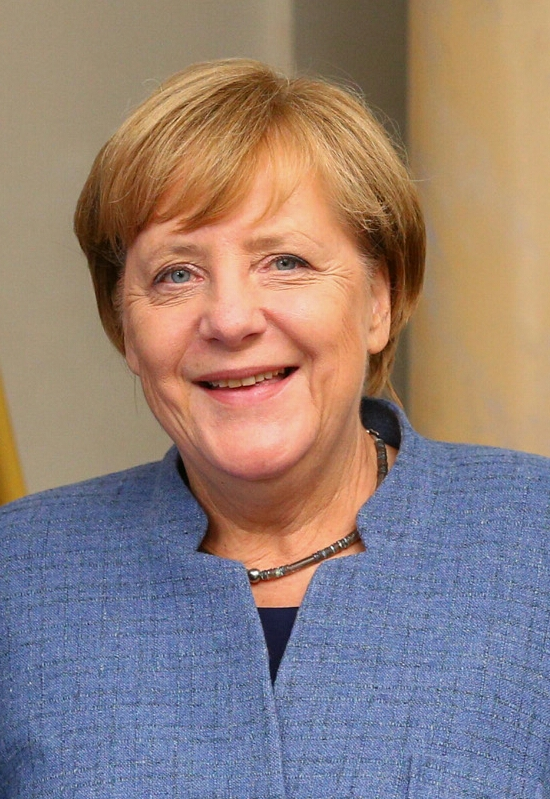

INFO:tensorflow:Restoring parameters from mobilenet_v2_1.0_224.ckpt
CPU times: user 3.86 s, sys: 139 ms, total: 4 s
Wall time: 2.53 s
Top 1 prediction:  475 cardigan 0.11903315


In [15]:
# Restore from checkpoint and do prediction
import numpy as np
from IPython import display
from datasets import imagenet
import PIL
display.display(display.Image('test.jpg', width=128))

with tf.Session() as sess:
    saver.restore(sess,  checkpoint)
    %time y = endpoints['Predictions'].eval(feed_dict={file_input: 'test.jpg'})

label_map = imagenet.create_readable_names_for_imagenet_labels()
print('Top 1 prediction: ', y.argmax(), label_map[y.argmax()], y.max())

## Movidius

<img src='assets/ncs_workflow.jpg'/>

[SDK](https://github.com/movidius/ncsdk) for Python, C++ | [Models](https://github.com/movidius/ncappzoo/) for Caffe, TensorFlow

<img src='assets/NCS1_ArchDiagram.jpg'/>

<img src='assets/pi_ncs_objectdetection_table.jpg'/>

[study](https://www.pyimagesearch.com/2018/02/19/real-time-object-detection-on-the-raspberry-pi-with-the-movidius-ncs/)

## Demo: Object Detection
---
Raspberry Pi 3 + Movidius in Python

In [53]:
import os
import sys
import platform

# utilities
sys.path += ['/ncappzoo/apps/ssd-object-detector']
from utils import deserialize_output

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9745  100  9745    0     0  13166      0 --:--:-- --:--:-- --:--:-- 13186


In [66]:
import numpy as np
import skimage.io
import skimage.transform
import PIL
from IPython import display

# pre-process the test image
IMAGE = 'assets/rub.jpg'
MEAN = 127.5
SCALE = 0.00789

raw_image = skimage.io.imread(IMAGE)
image = skimage.transform.resize(raw_image, [300, 300], preserve_range=True)
image = image[:, :, ::-1] # RGB -> BGR
image = image.astype(np.float16)
image = (image - np.float16(MEAN)) * SCALE

In [67]:
# load the labels
LABELS = '/ncappzoo/caffe/SSD_MobileNet/labels.txt'

labels = [line.rstrip('\n') for line in open(LABELS) if line != 'classes\n']

opened Movidius:  1.4
loaded graph:  /ncappzoo/caffe/SSD_MobileNet/graph
execution time: 79.9379 ms
96.0%	15: person: Top Left: (121, 24) Bottom Right: (300, 241)
96.0%	15: person: Top Left: (14, 128) Bottom Right: (300, 299)


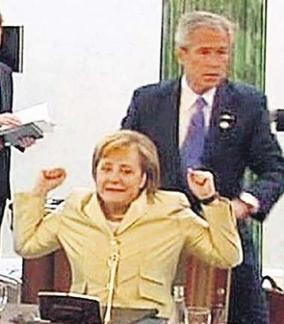

In [68]:
GRAPH = '/ncappzoo/caffe/SSD_MobileNet/graph'

import mvnc.mvncapi as mvapi
mvapi.SetGlobalOption(mvapi.GlobalOption.LOG_LEVEL, 0)

# find the first movidius
ncs_name = mvapi.EnumerateDevices()[0]
movidius = mvapi.Device(ncs_name)

# load the Neural Net
try:
    movidius.OpenDevice()
    print('opened Movidius: ', ncs_name)

    with open(GRAPH, mode='rb') as f:
        blob = f.read()
    graph = movidius.AllocateGraph(blob)
    print('loaded graph: ', GRAPH)

    # warm start with a dummy forward pass
    graph.LoadTensor(image, 'user object')
    output, userobj = graph.GetResult()

    # actual timed inference
    graph.LoadTensor(image, 'user object')
    output, userobj = graph.GetResult()
    inference_time = graph.GetGraphOption(mvapi.GraphOption.TIME_TAKEN)
    
    # deserialize and print output
    CONFIDENCE_THRESHOLD = 0.60
    output_dict = deserialize_output.ssd(output, CONFIDENCE_THRESHOLD, image.shape)

    print("execution time:", str(np.sum(inference_time)), "ms")

    for i in range( 0, output_dict['num_detections'] ):
        print( "%3.1f%%\t" % output_dict['detection_scores_' + str(i)]
               + labels[ int(output_dict['detection_classes_' + str(i)]) ]
               + ": Top Left: " + str( output_dict['detection_boxes_' + str(i)][0] )
               + " Bottom Right: " + str( output_dict['detection_boxes_' + str(i)][1] ) )    

    display.display(display.Image(IMAGE))
        
finally:
    graph.DeallocateGraph()
    movidius.CloseDevice()

## Embedded Learning Library (ELL)

<img src='assets/ell_workflow.png' width='50%'/>

[code](https://microsoft.github.io/ELL/)

## How fast on Raspberry Pi 3

<img src='assets/ell_pareto.png'/>

<img src='assets/ell_tiny.png'/>

[model file](https://microsoft.github.io/ELL/gallery/ILSVRC2012/BrazilianGuava.html)

## Audio Keyword Detection, Cortex M4
---

<video controls src='assets/ell_demo.mp4'/>

## Demo: Keyword Classification

---

Raspberry Pi 3

## Field Programmable Gate Arrays

<img src='assets/Hot-Chips-Stratix-10-board-1-.jpg'/>

<img src='assets/silicon_alternatives.png'/>

https://www.microsoft.com/en-us/research/blog/microsoft-unveils-project-brainwave/

## Neural Net Accelerators
- [comparison study](https://arxiv.org/abs/1712.08934)
- [Xilinx](https://github.com/Xilinx/RFNoC-HLS-NeuralNet)
- [PipeCNN](https://github.com/doonny/PipeCNN)

<img src='assets/Demo-DE5-net.gif'/>

## FPGAs on cloud
---
[ResNet50](https://github.com/Azure/aml-real-time-ai/blob/master/notebooks/resnet50/00_QuickStart.ipynb)

## Summary

Models
- Image Classification / Object Detection: MobileNetV2, SqueezeNet
- Keyword Classification: GRU + Classifier

Running Models
- CoreML
- TensorFlow / TensorFlow Lite
- Movidius Neural Compute Stick
- Embedded Learning Library
- FPGAs

In [12]:
# https://tomroelandts.com/articles/how-to-compute-colorful-fractals-using-numpy-and-matplotlib
import numpy as np

m = 480
n = 320
 
s = 300  # Scale.
x = np.linspace(-m / s, m / s, num=m).reshape((1, m))
y = np.linspace(-n / s, n / s, num=n).reshape((n, 1))
Z = np.tile(x, (n, 1)) + 1j * np.tile(y, (1, m))
 
C = np.full((n, m), -0.4 + 0.6j)
M = np.full((n, m), True, dtype=bool)
N = np.zeros((n, m))
for i in range(256):
    Z[M] = Z[M] * Z[M] + C[M]
    M[np.abs(Z) > 2] = False
    N[M] = i

Thank you!


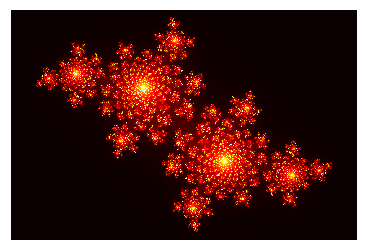

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_size_inches(m / 100, n / 100)
ax = fig.add_axes([0, 0, 1, 1], frameon=False, aspect=1)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(np.flipud(N), cmap='hot')

print('Thank you!')